## Generating the Truth (the observation values for assimilation)

We run the forward model and observe it at specific times.

In [1]:
import Simulator
import Observation

### Definition of grid and advection diffusion system

We solve the equation

$\frac{\partial X(t,s)}{\partial t} = \nabla \cdot D \nabla X(t,s) - v_t \cdot \nabla X(t,s) + \zeta X(t,s)  + \epsilon(t,s)$

where $\epsilon$ is $\mathcal{N}(0,\mathbf{R}_t)$ model error. 

As parameters we choose 
- $D=0.25$
- $\mathbf{v} = (1.0,0.0)^\top$
- $\zeta=-0.0001$.

For the numerical solution a temporal forward amd spatial central finite-difference scheme is employed such that 

$\mathbf{X}_{t+1} = \mathbf{M}\mathbf{X}_t + \mathbf
{\epsilon}_t$



In [2]:
grid = Simulator.Grid(nx=125,ny=75,dx=0.1,dy=0.1)
simulator = Simulator.Simulator(grid, D=0.25, v=[0.5,0.5])
simulator.to_file()

### Definition of initial state


In [3]:
import numpy as np

def initial(grid):
    """
    Constructing a Matern-type covariance prior with Matern-parameter phi
    where the matrix is normalized with the standard deviation
    """
    # INPUT! Bell mean
    bell_x = 0.25
    bell_y = 0.25
    sharpness = 2.0
    mean = np.zeros([grid.nx, grid.ny])
    for i in range(grid.nx):
        for j in range(grid.ny):
            mean[i,j] = np.exp(-sharpness*((i*grid.dx - bell_x*grid.nx*grid.dx)**2+(j*grid.dy - bell_y*grid.ny*grid.dy)**2))
    mean = np.reshape(mean,(grid.N_x,1), order="F")
    
    return mean

In [4]:
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def plot_truth(state):
        mean = np.reshape(state, (grid.ny,grid.nx))
        
        plt.imshow(mean, origin = "lower", vmin=0.0, vmax=1.0)
        plt.title("Truth")
        plt.colorbar(orientation="horizontal")
        plt.show()

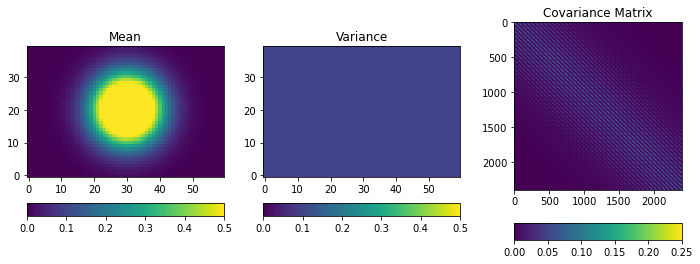

In [5]:
state = initial(grid=grid)

plot_truth(state)

### Setting observation moorings

In [6]:
import numpy as np

def observation_positions(grid, freq=10):
    poses = []
    for j in range(int(np.floor(grid.ny/freq))):
        for i in range(int(np.floor(grid.nx/freq))):
            poses.append([i*freq,j*freq])
    return poses


In [7]:
observation = Observation.Observation(simulator)


Remember to set observation positions and to set values!


In [8]:
poses = observation_positions(grid, freq=10)
observation.set_positions(poses)

### Temporal evolution of model

0


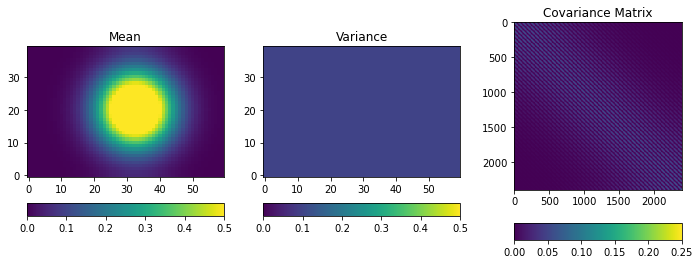

1


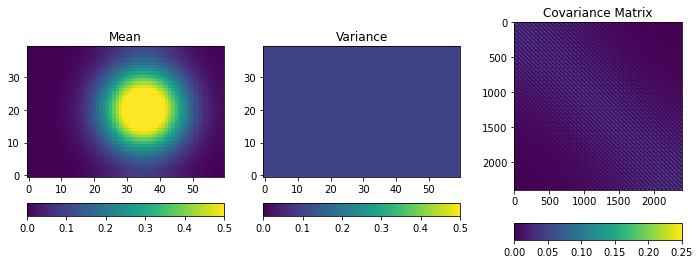

2


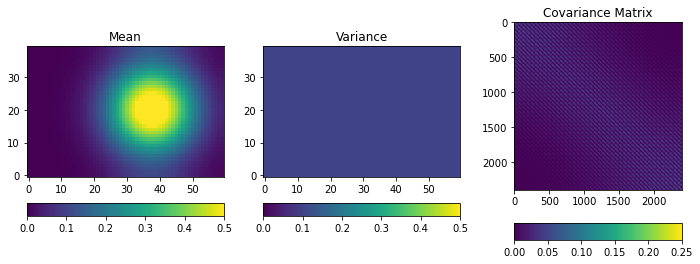

3


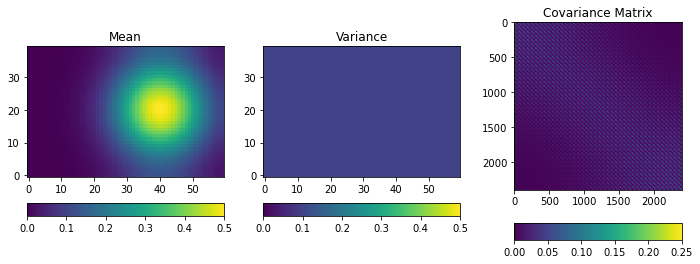

4


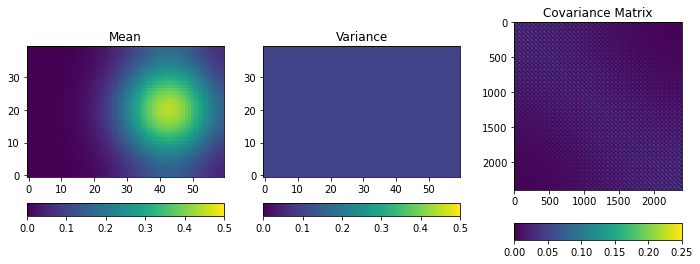

5


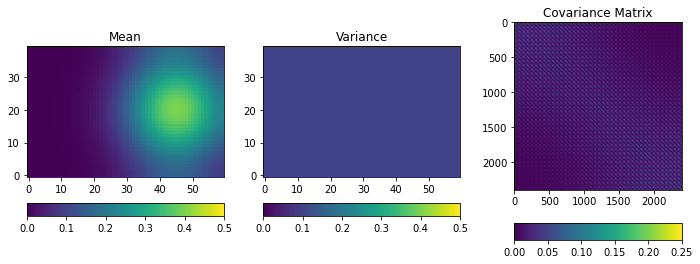

6


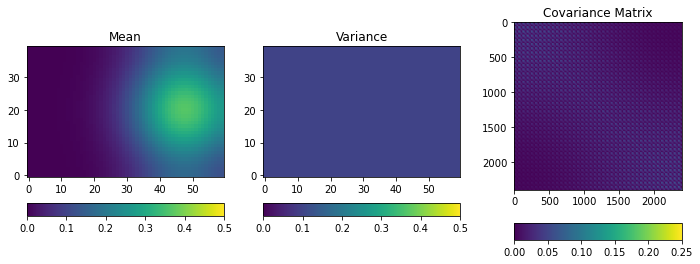

7


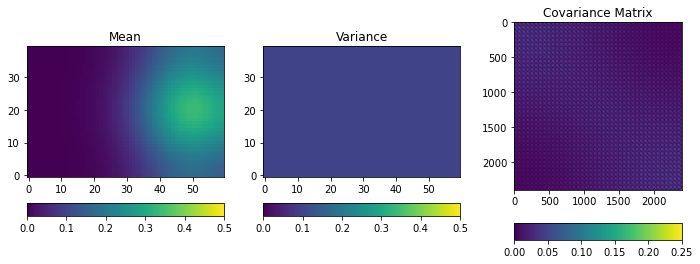

8


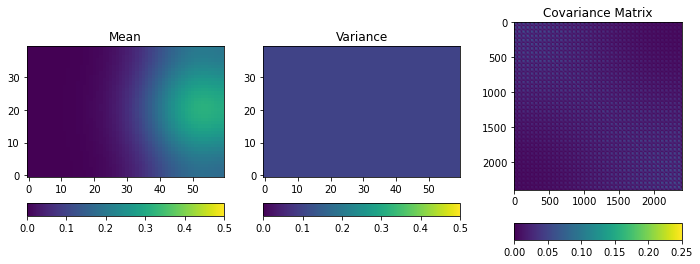

9


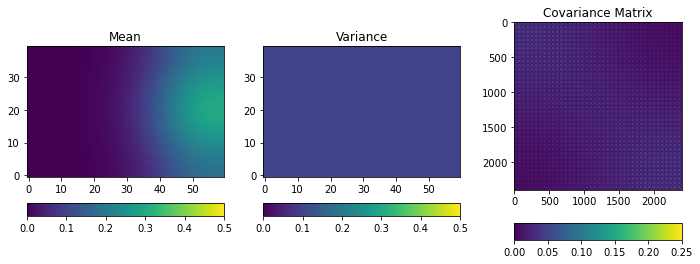

In [9]:
for t in range(10):
    print(t)
    state = simulator.propagate(state, steps=25)
    observation.observe(state)
    plot_truth(state)

In [10]:
observation.to_file()